https://www.kaggle.com/code/satishgunjal/binary-multiclass-classification-using-sklearn

In [1]:
import os
import wandb

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv

import pickle
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models
from torch.utils.data import DataLoader
import random
import torch.nn.functional as F

# from Dataset_ML import *
from Dataset_ML import *
from utils import *
from models import *
import timm

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn import metrics
from sklearn.metrics import roc_curve

import math
from sklearn.preprocessing import OneHotEncoder

In [2]:
import timm

In [3]:
def set_all_seeds(SEED):
    # REPRODUCIBILITY
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(SEED)
    random.seed(SEED)

In [4]:
def models_output_to_dataframe(df, model_name, labels, model_output):
    """
    모델 출력을 기존 데이터프레임에 추가하는 함수
    """
    temp_df = pd.DataFrame(model_output, columns=labels)
    temp_df.columns = [f'{model_name}_{label}' for label in labels]
    
    if df.empty:
        return temp_df
    else:
        return pd.concat([df, temp_df], axis=1)

In [5]:
labels = ['A-line', 'total-B-line', 'Consolidation', 'Pleural effusion']

models_output_df = pd.DataFrame(columns=labels)

In [6]:
class FrameLevelModel(nn.Module):
    def __init__(self, encoder, frame_fc_out):
        super(FrameLevelModel, self).__init__()
        # Initialize with the encoder and frame_fc_out from MedVidNet
        self.encoder = encoder
        self.frame_fc_out = frame_fc_out

    def forward(self, x):
        # Pass the input through the encoder to get frame-level features
        frame_features = self.encoder(x)
        # Pass the frame-level features through the frame_fc_out layer
        frame_outputs = self.frame_fc_out(frame_features)
        return frame_outputs

In [9]:
def frame_based_video_test(artifact_num, model_test_rate, data_type, fold_num, weight_path, base_path, batch_size, img_size):
    
    
    test_csv_path = os.path.join(base_path, f'clip/{artifact_num}_artifacts/temporally_separated_test.csv')
    
    # dataset
    test_dataset = video_dataset(test_csv_path, transforms = apply_transforms(mode=None), img_size = img_size, is_train = False)
    # dataloader
    test_dataloader =  torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle = False, drop_last=False)

    #len_dataloader
    len_test_dataset = len(test_dataloader.dataset)
    print(len_test_dataset)

    # set seed
    set_all_seeds(1234)

    sigmoid = nn.Sigmoid()

    # load imagenet pretrained model
    model = timm.create_model('densenet161', pretrained=False, num_classes=4)

    gpu_index = 0
    device = torch.device(f"cuda:{gpu_index}" if torch.cuda.is_available() else "cpu")

    check_point = torch.load(weight_path, map_location=device)

    # torch.nn.DataParallel을 사용하여 모델을 학습하고 저장한 경우에 이러한 접두어가 자주 발생
    if 'module' in list(check_point['model'].keys())[0]:
        # If so, remove the 'module.' prefix from the keys in the state_dict
        new_state_dict = {k[7:]: v for k, v in check_point['model'].items()}
        model.load_state_dict(new_state_dict)
    else:
        # If not using DataParallel, simply load the state_dict
        model.load_state_dict(check_point['model'])

    # model.load_state_dict(check_point['model'])
    model = model.to(device)
    
    # load best threshold
    best_val_thres = check_point['best_valid_thres']
    print(best_val_thres)
    
    model_outputs = []
    test_labels = []
    test_preds = []

    test_running_acc = 0.0

    model.eval() 
    with torch.no_grad():    
        
        for data in tqdm(test_dataloader, desc="Testing", unit="batch"):
#         for jdx, data in enumerate(test_dataloader):

            test_img, test_label, _ = data

            test_img = test_img.to(device)
            test_label = test_label.to(device)

            frames_preds = []
    #         print(test_img.shape)
            for t in range(test_img.size(1)):
                x_in2 = test_img[:, t, :, :, :]
                x_out = model(x_in2)
                frame_pred = sigmoid(x_out.squeeze())

                frame_pred_np = frame_pred.data.cpu().numpy()
                frames_preds.append(frame_pred_np)

            frame_2_video_preds_np = np.max(frames_preds, axis=0)
#             frame_2_video_preds_np = np.average(frames_preds, axis=0)
            model_outputs.append(frame_2_video_preds_np.tolist())
            
            frame_2_video_preds_np = np.where(frame_2_video_preds_np >= best_val_thres, 1., 0.)
#             frame_2_video_preds_np = np.where(frame_2_video_preds_np >= 0.5, 1., 0.)
            test_preds.append(frame_2_video_preds_np.tolist())

            test_labels.append(test_label[0].cpu().detach().numpy().tolist()) 

            np_test_label = test_label[0].cpu().numpy()

            test_accuracy = accuracy_score(np_test_label, frame_2_video_preds_np)

            test_running_acc += test_accuracy

#             print(f"prediction : {frame_2_video_preds_np}, test_label : {np_test_label}")
#             print(f"correct_num : {test_accuracy}")
#             print('-'*20)

    #         if jdx == 0:
    #             break

    test_accuracy = test_running_acc / len_test_dataset
    print(f"test_running_acc : {test_running_acc}")
        
    return test_accuracy, test_labels, test_preds, model_outputs, best_val_thres

In [136]:
# chk_std = "auc"
chk_std = "loss"

model_test_rate = "0.2"

fold_num = 2

version = 'version_1'

lr = 1e-6

data_type = "before_all_data"

frame_size = 256
# frame_size = 512

# batch_size = 32
batch_size = 128

# model_name = 'cnn_only'
# model_name = 'video_model'

# seed_num = 1234
seed_num = 234

chk_std = "loss"

model_name = 'densenet161'

# artifact_num = 4
artifact_num = 5

# no aug version
weight_path = f'/home/work/LUS/Results/frame_base/multi_label/seed_{seed_num}_test{model_test_rate}_std_{chk_std}_{data_type}_{version}_{artifact_num}_artifacts_{model_name}_lr{lr}_batch{batch_size}_{frame_size}_fold{fold_num}_noaug_checkpoint'

base_path = f'/home/work/LUS/Dataset/csv_files/temporally_separated_test_set'

test_accuracy, test_labels, test_preds, model_outputs, best_val_thres = frame_based_video_test(artifact_num = artifact_num,
                                                                                               model_test_rate=model_test_rate,
                                                                                               data_type=data_type,
                                                                                               fold_num=fold_num, 
                                                                                               weight_path=weight_path, 
                                                                                               base_path=base_path, 
                                                                                               batch_size=1,
                                                                                               img_size = frame_size)

392
[0.5609374, 0.25032347, 0.36832857, 0.1649006]


Testing: 100% 392/392 [07:53<00:00,  1.21s/batch]

test_running_acc : 282.5


In [137]:
model_name = 'cnn_only_max'

labels = ['A-line', 'total-B-line', 'Consolidation', 'Pleural effusion']

models_output_df = pd.DataFrame(columns=labels)

models_output_df = models_output_to_dataframe(models_output_df, model_name, labels, model_outputs)
models_output_df.head()

,cnn_only_max_A-line,cnn_only_max_total-B-line,cnn_only_max_Consolidation,cnn_only_max_Pleural effusion
0,0.898172,0.153494,0.158791,0.163383
1,0.903162,0.159825,0.119992,0.158505
2,0.914820,0.160971,0.166886,0.166200
3,0.889128,0.167735,0.153903,0.145499
4,0.862831,0.167735,0.153903,0.151047


In [138]:
print(f'best_threshold : {best_val_thres}')

best_threshold : [0.5609374, 0.25032347, 0.36832857, 0.1649006]


In [139]:
from sklearn.metrics import ConfusionMatrixDisplay, multilabel_confusion_matrix

# test_labels = [idx[0] for idx in test_labels]
test_labels = [[int(y) for y in z] for z in test_labels]

confusion_mat = multilabel_confusion_matrix(test_labels, test_preds)

all_labels = [
            'A-line',
            'B-lines',
#             'B-line',
#             'Confluent B-line',
            'Consolidation',
            'Pleural effusion'
            ]

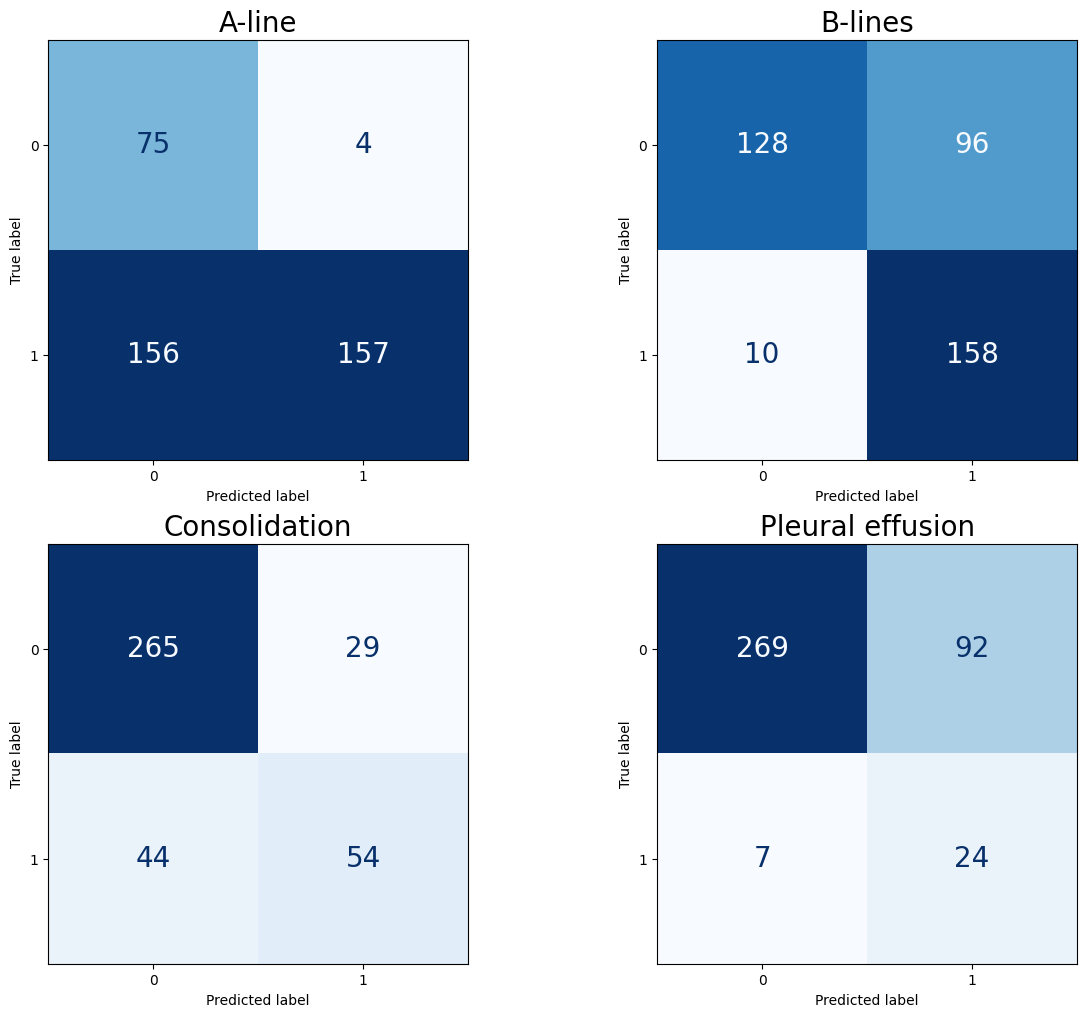

In [140]:
# ConfusionMatrixDisplay 함수를 이용하여 2행 3열로 시각화합니다.
# figsize를 조정하여 적당한 크기로 만듭니다.
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
plt.subplots_adjust(wspace=0.1, hspace=0.2)

# axs는 2x3 array이므로 axs.flat으로 iterator를 생성합니다.
ax_iterator = iter(axs.flat)

for idx, label in enumerate(all_labels):
    ax = next(ax_iterator)  # 다음 subplot을 가져옵니다.
    disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat[idx], display_labels=[0, 1])
    disp.plot(ax=ax, cmap='Blues', colorbar=False)  # 각 subplot에 colorbar를 제거합니다.
    ax.set_title(label, fontsize=20)
    
    # 각 축에 대해 텍스트 크기를 설정합니다.
    for texts in [disp.text_]:
        for text in texts.flatten():
            text.set_fontsize(20)  # 숫자 텍스트의 크기를 조정합니다.

# 남는 subplot을 숨깁니다.
for ax in ax_iterator:
    ax.set_visible(False)

In [141]:
# precision_score, recall_score, f1_score 함수를 사용하여 각 레이블별 성능을 계산합니다.
from sklearn.metrics import precision_score, recall_score, f1_score

test_prediction_flat = np.array(test_preds).flatten()
test_labels_flat = np.array(test_labels).flatten()

precision = precision_score(test_labels_flat, test_prediction_flat, average='weighted')
recall = recall_score(test_labels_flat, test_prediction_flat, average='weighted')
f1 = f1_score(test_labels_flat, test_prediction_flat, average='weighted')

print('Micro-averaged precision : ', precision)
print('recall : ', recall)
print('f1-score : ', f1)

Micro-averaged precision :  0.721001202910845
recall :  0.7206632653061225
f1-score :  0.7208275046420242


In [142]:
print(classification_report(
    test_labels,
    test_preds,
    output_dict=False,
    target_names=[
            'A-line',
            'B-lines',
#             'B-line',
#             'Confluent B-line',
            'Consolidation',
            'Pleural effusion'
            ]
))

                  precision    recall  f1-score   support

          A-line       0.98      0.50      0.66       313
         B-lines       0.62      0.94      0.75       168
   Consolidation       0.65      0.55      0.60        98
Pleural effusion       0.21      0.77      0.33        31

       micro avg       0.64      0.64      0.64       610
       macro avg       0.61      0.69      0.58       610
    weighted avg       0.79      0.64      0.66       610
     samples avg       0.71      0.69      0.66       610



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [143]:
from numpy import argmax

# calculate roc curves
fpr, tpr, thresholds = roc_curve(np.array(test_labels)[:, 0], np.array(model_outputs)[:, 0])

# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('A-line results')
print('Best Threshold=%f, sensitivity = %.3f, specificity = %.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

y_prob_pred = (np.array(model_outputs)[:, 0] >= best_thresh).astype(bool)
print(classification_report(np.array(test_labels)[:, 0], y_prob_pred, target_names=['A-line', 'Others']))

A-line results
Best Threshold=0.281342, sensitivity = 0.633, specificity = 0.937, J=0.569
              precision    recall  f1-score   support

      A-line       0.39      0.94      0.55        79
      Others       0.98      0.63      0.77       313

    accuracy                           0.69       392
   macro avg       0.68      0.78      0.66       392
weighted avg       0.86      0.69      0.72       392



In [144]:
from numpy import argmax

# calculate roc curves
fpr, tpr, thresholds = roc_curve(np.array(test_labels)[:, 1], np.array(model_outputs)[:, 1])

# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('B-lines results')
print('Best Threshold=%f, sensitivity = %.3f, specificity = %.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

y_prob_pred = (np.array(model_outputs)[:, 1] >= best_thresh).astype(bool)
print(classification_report(np.array(test_labels)[:, 1], y_prob_pred, target_names=['B-line', 'Others']))

B-lines results
Best Threshold=0.566751, sensitivity = 0.893, specificity = 0.804, J=0.696
              precision    recall  f1-score   support

      B-line       0.91      0.80      0.85       224
      Others       0.77      0.89      0.83       168

    accuracy                           0.84       392
   macro avg       0.84      0.85      0.84       392
weighted avg       0.85      0.84      0.84       392



In [145]:
from numpy import argmax

# calculate roc curves
fpr, tpr, thresholds = roc_curve(np.array(test_labels)[:, 2], np.array(model_outputs)[:, 2])

# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Consolidation results')
print('Best Threshold=%f, sensitivity = %.3f, specificity = %.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

y_prob_pred = (np.array(model_outputs)[:, 2] >= best_thresh).astype(bool)
print(classification_report(np.array(test_labels)[:, 2], y_prob_pred, target_names=['Consolidation', 'Others']))

Consolidation results
Best Threshold=0.267249, sensitivity = 0.653, specificity = 0.874, J=0.527
               precision    recall  f1-score   support

Consolidation       0.88      0.87      0.88       294
       Others       0.63      0.65      0.64        98

     accuracy                           0.82       392
    macro avg       0.76      0.76      0.76       392
 weighted avg       0.82      0.82      0.82       392



In [146]:
from numpy import argmax

# calculate roc curves
fpr, tpr, thresholds = roc_curve(np.array(test_labels)[:, 3], np.array(model_outputs)[:, 3])

# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Pleural effusion results')
print('Best Threshold=%f, sensitivity = %.3f, specificity = %.3f, J=%.3f' % (best_thresh, tpr[ix], 1-fpr[ix], J[ix]))

y_prob_pred = (np.array(model_outputs)[:, 3] >= best_thresh).astype(bool)
print(classification_report(np.array(test_labels)[:, 3], y_prob_pred, target_names=['Pleural effusion', 'Others']))

Pleural effusion results
Best Threshold=0.295822, sensitivity = 0.774, specificity = 0.975, J=0.749
                  precision    recall  f1-score   support

Pleural effusion       0.98      0.98      0.98       361
          Others       0.73      0.77      0.75        31

        accuracy                           0.96       392
       macro avg       0.85      0.87      0.86       392
    weighted avg       0.96      0.96      0.96       392



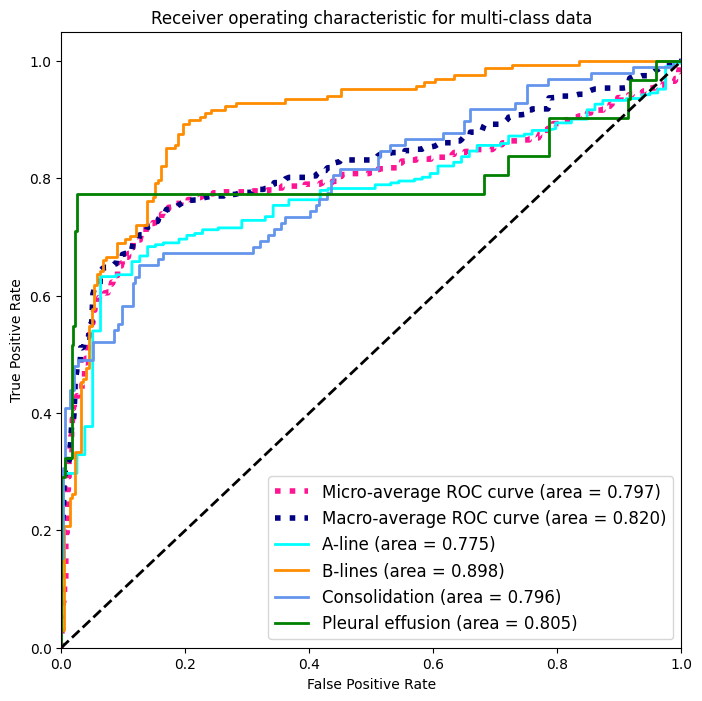

In [147]:
from itertools import cycle
from sklearn.metrics import roc_curve, auc


# ROC curve를 계산하고 시각화합니다.
n_classes = len(test_labels[0])
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(test_labels)[:, i], np.array(model_outputs)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 마이크로 평균 ROC curve를 계산합니다.
fpr["micro"], tpr["micro"], _ = roc_curve(np.array(test_labels).ravel(), np.array(model_outputs).ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# 모든 레이블에 대한 평균 ROC curve를 계산합니다.
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
mean_tpr /= n_classes
fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# ROC curve를 그래프로 시각화합니다.
plt.figure(figsize=(8, 8))
lw = 2
plt.plot(fpr["micro"], tpr["micro"], label='Micro-average ROC curve (area = {0:0.3f})'
''.format(roc_auc["micro"]), color='deeppink', linestyle=':', linewidth=4)
plt.plot(fpr["macro"], tpr["macro"], label='Macro-average ROC curve (area = {0:0.3f})'
''.format(roc_auc["macro"]), color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red'])
all_labels = [
            'A-line',
            'B-lines',
#             'B-line',
#             'Confluent B-line',
            'Consolidation',
            'Pleural effusion'
            ]

for i, label, color in zip(range(len(all_labels)), all_labels, colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
            label='{0} (area = {1:0.3f})'
            ''.format(label, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for multi-class data')
plt.legend(loc="lower right", fontsize='large')
plt.show()


In [148]:
def gt_to_dataframe(df, labels, model_output):
    """
    모델 출력을 기존 데이터프레임에 추가하는 함수
    """
    temp_df = pd.DataFrame(model_output, columns=labels)
    temp_df.columns = [f'{label}' for label in labels]
    
    if df.empty:
        return temp_df
    else:
        return pd.concat([df, temp_df], axis=1)

In [149]:
labels = ['A-line', 'total-B-line', 'Consolidation', 'Pleural effusion']

models_gt_df = pd.DataFrame(columns=labels)

models_gt_df = gt_to_dataframe(models_gt_df, labels, test_labels)
models_gt_df.head()

,A-line,total-B-line,Consolidation,Pleural effusion
0,1,0,0,0
1,1,0,0,0
2,1,0,0,0
3,1,0,0,0
4,1,0,0,0


In [150]:
print(len(models_output_df))
print(len(models_gt_df))

392
392


In [151]:
models_output_df

,cnn_only_max_A-line,cnn_only_max_total-B-line,cnn_only_max_Consolidation,cnn_only_max_Pleural effusion
0,0.898172,0.153494,0.158791,0.163383
1,0.903162,0.159825,0.119992,0.158505
2,0.914820,0.160971,0.166886,0.166200
3,0.889128,0.167735,0.153903,0.145499
4,0.862831,0.167735,0.153903,0.151047
...,...,...,...,...
387,0.133937,0.957542,0.087462,0.132008
388,0.133937,0.973266,0.095793,0.131585
389,0.086390,0.969617,0.095793,0.137385
390,0.085063,0.969617,0.087792,0.135401


In [152]:
models_output_df.to_csv(f'/home/work/LUS/Results/model_output_csv/video_level/temporally_separated_test/densenet_161/{artifact_num}_artifacts_batch{batch_size}_fold_{fold_num}_densenet_161_output.csv', index = False)

In [153]:
# models_gt_df.to_csv(f'/home/work/LUS/Results/model_output_csv/video_level/temporally_separated_test/5_artifacts_fold_{fold_num}_video_level_gt.csv', index = False)

In [154]:
from scipy.stats import norm
from compare_auc_delong import *

def delong_auc_ci(y_true, y_pred, alpha=0.95):
    """
    DeLong 방법을 이용하여 AUC와 95% 신뢰 구간 계산
    Args:
    - y_true: 실제 레이블 값 (0과 1로 구성된 numpy 배열)
    - y_pred: 예측 확률값 (numpy 배열)
    - alpha: 신뢰수준 (기본값 0.95)

    Returns:
    - auc: AUC 값
    - ci: AUC에 대한 신뢰 구간 (하한, 상한)
    """
    auc, auc_var = delong_roc_variance(y_true, y_pred)
    auc_std = np.sqrt(auc_var)

    # 신뢰 구간 계산
    lower_upper_q = np.array([0.5 - alpha / 2, 0.5 + alpha / 2])
    ci = norm.ppf(lower_upper_q, loc=auc, scale=auc_std)
    
    # 신뢰 구간의 범위를 0과 1 사이로 조정
    ci[ci < 0] = 0
    ci[ci > 1] = 1

    return auc, ci

In [155]:
def cal_CI(gt_df, method_df):
    CI_values = {}
    auc_values = {}
    for idx in range(len(labels)):
        gt_series = gt_df.iloc[:, idx]
        method__series = method_df.iloc[:, idx]
        
        auc, ci = delong_auc_ci(gt_series, method__series)
        
        CI_values[labels[idx]] = ci
        auc_values[labels[idx]] = auc.item()
        
    return CI_values, auc_values

In [156]:
CIs, AUCs = cal_CI(models_gt_df, models_output_df)

results = {
    'Label': list(AUCs.keys()),
    'AUC': list(AUCs.values()),
    '95% CI Lower Bound': [ci[0] for ci in CIs.values()],
    '95% CI Upper Bound': [ci[1] for ci in CIs.values()]
}
results_df = pd.DataFrame(results)
results_df

/home/work/LUS/code/video_base/pda_detection/code/compare_auc_delong.py:297: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  predictions_sorted_transposed = predictions[np.newaxis, order]


,Label,AUC,95% CI Lower Bound,95% CI Upper Bound
0,A-line,0.775205,0.728007,0.822403
1,total-B-line,0.898384,0.866901,0.929867
2,Consolidation,0.796370,0.739550,0.853189
3,Pleural effusion,0.804843,0.681812,0.927875
